Based off of these Tutorials:

https://blog.quantopian.com/markowitz-portfolio-optimization-2/

http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

import datetime
import numpy as np
import pandas_datareader.data as web
import pandas as pd
from scipy.stats import norm

# Turn off progress printing 
solvers.options['show_progress'] = False

### Assumes 4 assets, each with a return series of length 1000 generated by numpy.random.randn

In [24]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

In [25]:
return_vec

array([[-1.0856306 ,  0.99734545,  0.2829785 , ..., -0.90932702,
         0.47026375, -1.11143045],
       [-0.74882747,  0.56759473,  0.71815054, ..., -0.35929672,
        -1.60969508,  0.01357006],
       [-1.77422355, -1.20137731,  1.09625679, ...,  2.04043199,
         1.01591697, -1.63378817],
       [-0.45059869,  0.60959032,  1.17374438, ..., -0.1227329 ,
         1.79448602, -0.32050951]])

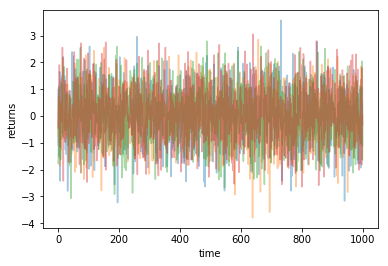

In [26]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [27]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


In [28]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [29]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

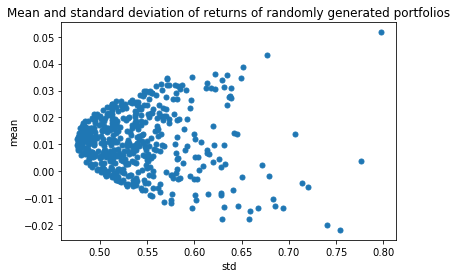

In [30]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

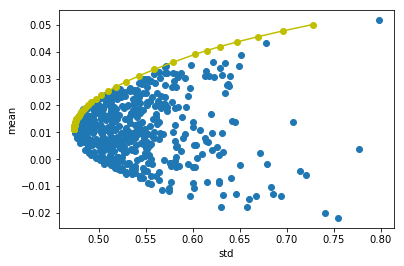

In [31]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [32]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


### We aren't using Quantopian's data source, but pandas webreader to pull data from Google Finance instead

We'll run this on a subset of the Quantopian portfolio to reduce calculation time

In [33]:
stocks=['IBM', 'GLD', 'XOM', 'AAPL']#, 'MSFT', 'TLT', 'SHY']
end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

In [34]:
# Grab the closing prices for our portfolio from Google Finance

stock_closing_prices  = {}
for ticker in stocks:
    price_data = web.DataReader(ticker, 'google', start, end)
    stock_closing_prices[ticker] = price_data['Close']

In [35]:
#Check in on our closing prices
stock_closing_prices['IBM'].head()

Date
2007-11-13    105.27
2007-11-14    103.44
2007-11-15    103.60
2007-11-16    104.79
2007-11-19    102.22
Name: Close, dtype: float64

In [36]:
data = pd.DataFrame(stock_closing_prices)

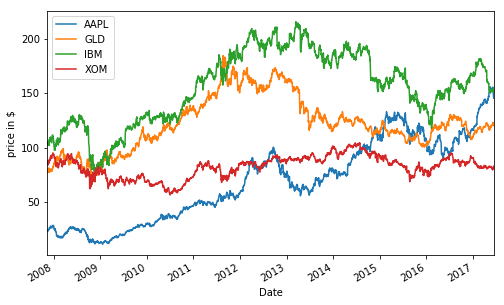

In [37]:
data.plot(figsize=(8,5))
plt.ylabel('price in $')

In [38]:
data_returns = data.pct_change()

### First we generate a series of returns

In [39]:
data_returns.fillna(0, axis = 1, inplace = True)
data_returns.head()

,AAPL,GLD,IBM,XOM
Date,,,,
2007-11-13,0.000000,0.000000,0.000000,0.000000
2007-11-14,-0.022652,0.014661,-0.017384,-0.006561
2007-11-15,-0.010957,-0.029023,0.001547,-0.021087
2007-11-16,0.012782,-0.002566,0.011486,0.007220
2007-11-19,-0.014724,-0.006559,-0.024525,-0.011633


In [40]:
n_portfolios = 25000
means, stds = np.column_stack([
    random_portfolio(data_returns) 
    for _ in xrange(n_portfolios)
])

### We need to annualize our mean returns and std. deviations

Need to generate annualized expected return and volatility for our frontier

In [41]:
means = means * 252
stds = stds *np.sqrt(252)

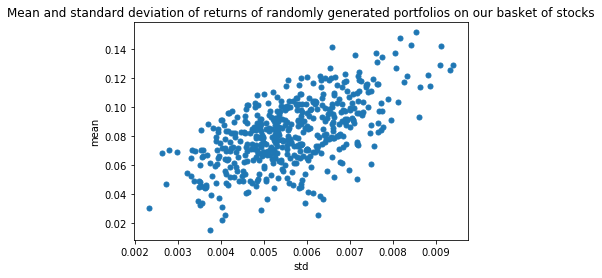

In [32]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios on our basket of stocks')

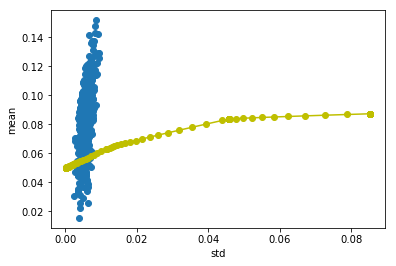

In [33]:
weights, returns, risks = optimal_portfolio(data_returns)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

## This seems wrong and will need to be fixed

In [6]:
# Using the Python for Finance Method

stock = ['AAPL']

data = web.DataReader(stock, data_source = "google", start = '01/01/2010')['Close']

returns = data.pct_change()

mean_return = returns.mean()
return_std = returns.std()

ann_return = round(mean_return *252, 2)
ann_std = round(return_std *np.sqrt(252), 2)

print ('The ann. mean return of the stock {} is {} and the annualised volatility is {}').format(stock[0], ann_return, ann_std)

The ann. mean return of the stock AAPL is 0.24 and the annualised volatility is 0.26


This gives us the annualized mean return and volatility for a single stock, but what if we had a portfolio of stocks?

In [13]:
#stocks in our portfolio
stocks = ['AAPL','MSFT','AMZN','YHOO']

#pull the price data for each stock
data = web.DataReader(stocks, data_source = 'google', start = '01/01/2010')['Close']

#convert daily stock prices into daily returns
returns = data.pct_change()

#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

Let's assign arbitrary weights to our holdings for now

In [15]:
#array of portfolio weights for each stock
weights = np.asarray([0.5, 0.2, 0.2, 0.1])
portfolio_return = round(np.sum(mean_daily_returns * weights) * 252, 2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

print('Portfolio expected annualized return is {} and volatility is {}').format(portfolio_return,portfolio_std_dev)

Portfolio expected annualized return is 0.23 and volatility is 0.2


Now that we have calculated portfolio annualized return and volatility for a given weight, we can then use a monte carlo simulation to see how varying the weights affects these two values.

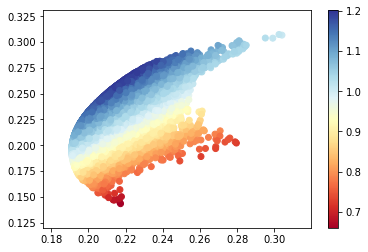

In [18]:
#Number of random portfolio weights to test
num_portfolios = 25000

#set up array to hold results
results = np.zeros((3,num_portfolios))

for i in xrange(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(4)
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #Store Sharpe Ratio (return / vol) 
    #risk free rate component excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    
#convert results array to a Pandas Dataframe
results_frame = pd.DataFrame(results.T, columns = ['ret','stdev','sharpe'])

#create a scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.colorbar()

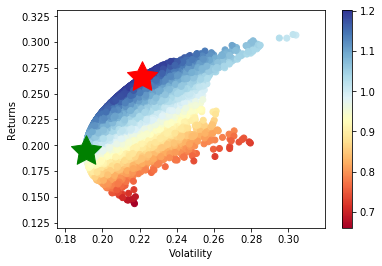

In [19]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000)

In [20]:
print(max_sharpe_port)

ret       0.265693
stdev     0.221148
sharpe    1.201423
Name: 10544, dtype: float64


In [21]:
print(min_vol_port)

ret       0.194259
stdev     0.191106
sharpe    1.016502
Name: 22953, dtype: float64
